In [48]:
# Dependencies and Setup

import requests
import pandas as pd
import numpy as np
import us
import matplotlib.pyplot as plt
import gmaps
from scipy.stats import linregress

bully_data_file = "../Output/bully15.csv"
ed_data_file = "../Output/ed15.csv"

from config import gkey
gmaps.configure(api_key=gkey)

In [ ]:
#Bullying & Harassment Allegations API Pull 

base_url = "https://educationdata.urban.org"
year = "2015"

bully_dict = {}
bully_list = []

for i in range(95):
    page_num = i + 1
    bully_url = base_url + f"/api/v1/schools/crdc/harassment-or-bullying/{year}/allegations/?page={page_num}"

    response = requests.get(bully_url).json()
    results_list = response["results"]

    for j in range(len(results_list)):

        state_fips = str(response["results"][j]["fips"])
        state_name = us.states.lookup(state_fips)
        
        if (state_name == None) : 
            state_fips = "0" + str(response["results"][j]["fips"])
            state_name = us.states.lookup(state_fips)
        
        sex = int(response["results"][j]["allegations_harass_sex"])
        race = int(response["results"][j]["allegations_harass_race"])
        disability = int(response["results"][j]["allegations_harass_disability"])
        orientation = int(response["results"][j]["allegations_harass_orientation"])
        religion = int(response["results"][j]["allegations_harass_religion"])
        
        if (sex != -1 and race != -1 and disability != -1 and orientation != -1 and religion != -1):
            if (sex != -2 and race != -2 and disability != -2 and orientation != -2 and religion != -2):
                bully_dict = {"State": state_name, "Alleged_Sexual_Harassment": sex, "Alleged_Racial_Harassment": race, 
                             "Alleged_Disability_Harassment": disability, "Alleged_Orientation_Harassment": orientation, 
                              "Alleged_Religion_Harassment": religion}
                bully_list.append(bully_dict)

    print(f"Processing page {page_num} of 94")
    
    
bully_df = pd.DataFrame(bully_list)
bully_df

In [50]:
# ** RUN THIS CELL TO READ IN BULLYING DATA (2015)! **

bully_df = pd.read_csv("../Output/bully15.csv")
bully_df.head()

,State,Alleged_Sexual_Harassment,Alleged_Racial_Harassment,Alleged_Disability_Harassment,Alleged_Orientation_Harassment,Alleged_Religion_Harassment
0,Alabama,0,0,0,0,0
1,Alabama,0,0,0,0,0
2,Alabama,1,1,0,1,0
3,Alabama,0,2,0,0,0
4,Alabama,0,0,0,0,0


In [51]:
# Sum allegations to make "Total_Allegations" column

bully_df["State"] = bully_df["State"].astype(str)
bully_df["Total_Allegations"]= bully_df["Alleged_Sexual_Harassment"] + bully_df["Alleged_Racial_Harassment"] + bully_df["Alleged_Disability_Harassment"] + bully_df["Alleged_Orientation_Harassment"]+ bully_df["Alleged_Religion_Harassment"]
bully_df

,State,Alleged_Sexual_Harassment,Alleged_Racial_Harassment,Alleged_Disability_Harassment,Alleged_Orientation_Harassment,Alleged_Religion_Harassment,Total_Allegations
0,Alabama,0,0,0,0,0,0
1,Alabama,0,0,0,0,0,0
2,Alabama,1,1,0,1,0,3
3,Alabama,0,2,0,0,0,2
4,Alabama,0,0,0,0,0,0
...,...,...,...,...,...,...,...
92621,Wyoming,5,13,6,0,0,24
92622,Wyoming,1,0,0,0,0,1
92623,Wyoming,0,0,0,1,0,1
92624,Wyoming,0,0,0,0,0,0


In [52]:
# Group by State to get counts for alleged bullying/harassment cases by state

bully_df["State"] = bully_df["State"].astype(str)
grouped_bully_df = bully_df.groupby("State").sum()

allegations_by_state = pd.DataFrame(grouped_bully_df)
# allegations_by_state["Total_Allegations"].plot(kind="bar")
allegations_by_state.head()

,Alleged_Sexual_Harassment,Alleged_Racial_Harassment,Alleged_Disability_Harassment,Alleged_Orientation_Harassment,Alleged_Religion_Harassment,Total_Allegations
State,,,,,,
Alabama,569,501,81,193,13,1357
Alaska,27,17,4,11,0,59
Arizona,1547,485,218,426,104,2780
Arkansas,595,411,102,111,8,1227
California,8640,3537,2037,2110,1296,17620


In [53]:
# Write allegations_by_state DataFrame to csv 

with open(bully_data_file, "w") as bully:
    bully.write("State,Alleged_Sexual_Harassment,Alleged_Racial_Harassment,Alleged_Disability_Harassment,Alleged_Orientation_Harassment,Alleged_Religion_Harassment\n")
    
    for index,row in bully_df.iterrows():
        state = row["State"]
        sex = row["Alleged_Sexual_Harassment"]
        race = row["Alleged_Racial_Harassment"]
        disability = row["Alleged_Disability_Harassment"]
        orientation = row["Alleged_Orientation_Harassment"]
        religion = row["Alleged_Religion_Harassment"]
        
        bully.write(f"{state},{sex},{race},{disability},{orientation},{religion}\n")           
                

In [ ]:
# NOTE: Before running following cell, unzip "../Input/Archive"

In [54]:
#Pull in Ed Data for all States

ed_data1 = pd.read_csv("../Input/Archive/2015_performance_data1.csv")
ed_data1["State"] = ed_data1["State"].astype(str)
ed_data1 = ed_data1.loc[ed_data1["State"]!="ILLINOIS"]

ed_data2 = pd.read_csv("../Input/Archive/2015_performance_data2.csv", low_memory=False)
ed_data2["State"] = ed_data2["State"].astype(str)

ed_data3 = pd.read_csv("../Input/Archive/2015_performance_data3.csv")
ed_data3["State"] = ed_data3["State"].astype(str)

ed_data4 = pd.read_csv("../Input/Archive/2015_performance_data4.csv", low_memory=False)

ed_data5 = pd.read_csv("../Input/Archive/2015_performance_data5.csv", low_memory=False)
ed_data5["State"] = ed_data5["State"].astype(str)

ed_data6 = pd.read_csv("../Input/Archive/2015_performance_data6.csv", low_memory=False)
ed_data6["State"] = ed_data6["State"].astype(str)

In [56]:
# Create combined Ed DataFrame

frames = [ed_data1,ed_data2,ed_data3,ed_data4,ed_data5,ed_data6]

ed_data = pd.concat(frames)
ed_data.head(10)

,School Year,State,NCES LEA ID,Local Education Agency (School District) Name,Data Group ID,Data Description,Value,Number of Valid Test Takers,Academic Subject,Category,Age/Grade,Grade Level,Mckinney-Vento Subgrantee Status,LEP Status Description,English Proficiency,"Title I, Part A Program Type",Language,"Title I, Part D Program Type",Progress Level
0,2015-2016,ALABAMA,NaN,NaN,676,Performance of All English Learners on English...,20.1,20472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-2016,ALABAMA,100002.0,Alabama Youth Services,676,Performance of All English Learners on English...,S,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-2016,ALABAMA,100005.0,Albertville City,676,Performance of All English Learners on English...,10%,729.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-2016,ALABAMA,100006.0,Marshall County,676,Performance of All English Learners on English...,20%,317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-2016,ALABAMA,100007.0,Hoover City,676,Performance of All English Learners on English...,21%,559.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-2016,ALABAMA,100008.0,Madison City,676,Performance of All English Learners on English...,35-39%,289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-2016,ALABAMA,100011.0,Leeds City,676,Performance of All English Learners on English...,15-19%,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-2016,ALABAMA,100012.0,Boaz City,676,Performance of All English Learners on English...,6-9%,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-2016,ALABAMA,100013.0,Trussville City,676,Performance of All English Learners on English...,40-59%,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-2016,ALABAMA,100018.0,Alabama School of Fine Arts,676,Performance of All English Learners on English...,S,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
ed_data["Data Description"].value_counts()

Performance on Statewide Mathematics Assessment                                   1303919
Participation on Statewide Reading/Language Arts Assessment                       1299254
Participation on Statewide Mathematics Assessment                                 1297603
Performance on Statewide Reading/Language Arts Assessment                         1286713
Four-Year Adjusted-Cohort Graduation Rates                                          97042
Performance of All English Learners on English Language Proficiency Assessment      12336
Performance on Statewide Science Assessment                                          3244
Name: Data Description, dtype: int64

In [ ]:
# Clean Ed Data

# Remove all single-valued performance assessment rows (want ranges)

single_index_list = []
range_index_list = []

for index,row in ed_data.iterrows():
    try:
        float(row["Value"])
        single_index_list.append(index)
    except:
        pass

ed_data = ed_data.drop(labels = single_index_list)

In [77]:
# Remove non-numeric ranges from performance assessment

ed_data = ed_data.loc[(ed_data["Value"] != "PS") & (ed_data["Value"] != ".") & (ed_data["Value"] != "S") & (ed_data["Value"] != "-")]

In [ ]:
# Value Key: "GE" = Greater than or equal to (%)
#            "LE" = Less than or equal to (%)
#            "GT" = Greater than (%)
#            "LT" = Less than (%)
#            "PS" = Data suppressed

In [15]:
value_list = ed_data["Value"].value_counts()
value_list.loc[value_list > 100]

GE50      334422
GE95      260280
GE80      187748
GE90      173559
LT50      144349
GE99       76321
21-39      45105
40-59      43169
LE20       41065
60-79      37979
30-39      25643
40-49      25248
90-94      24702
50-59      24412
20-29      23907
60-69      22624
45-49      22075
55-59      22016
50-54      21908
60-64      21495
40-44      21407
35-39      20917
30-34      20811
70-79      20721
80-89      20415
65-69      20342
25-29      19252
70-74      18946
11-19      18130
20-24      17596
75-79      17240
85-89      15996
80-84      15879
15-19      15374
LE10       13810
10-14      12276
6-9         7237
LE5         5381
<50%         998
<=20%        354
21-39%       330
11-19%       199
15-19%       195
25-29%       194
20-29%       189
20-24%       183
40-59%       179
<=10%        172
10-14%       159
>=50%        156
30-39%       156
30-34%       142
35-39%       124
Name: Value, dtype: int64

In [16]:
#Clean Ed Data columns

ed_data = ed_data.replace({"GE95":"90-100","GE90":"90-100","GE80":"80-89","GE99":"90-100","LE20":"10-19","60-69":"60-79",
                           "20-29":"20-39","55-59":"50-59","50-54":"50-59","60-64":"60-79","40-44":"40-49","35-39":"20-39",
                           "30-34":"20-39","70-79":"60-79","25-29":"20-39","70-74":"60-79","11-19":"10-19","20-24":"20-39",
                           "75-79":"60-79","85-89":"80-89","80-84":"80-89","15-19":"10-19","LE10":"0-9","10-14":"10-19",
                           "6-9":"0-9","LE5":"0-9","<50%":"LT50","<=20%":"10-19",
                           "30-39":"20-39","<50":"LT50","<=20":"10-19","21-39%":"20-39","11-19%":"10-19",
                         "15-19%":"10-19","25-29%":"20-39","20-29%":"20-39","20-24%":"20-39","<=10%":"0-9","10-14%":"10-19",
                         ">=50%":"GE50","30-39%":"20-39","30-34%":"20-39","35-39%":"20-39"})

In [ ]:
# Write cleaned Ed Data to csv

with open(ed_data_file, "w") as ed:
    ed.write("School Year,State,Description,Value,Number of Test Takers,Academic Subject,Category,Age/Grade,Grade Level,LEP Status,English Proficiency,Language,Progress Level\n")
             
    for index,row in ed_data.iterrows():
        school_year = str(row["School Year"])
        state = str(row["State"])
        description = str(row["Data Description"])
        value = str(row["Value"])
        test_takers = float(row["Number of Valid Test Takers"])
        subject = str(row["Academic Subject"])
        category = str(row["Category"])
        age_grade = str(row["Age/Grade"])
        grade_level = str(row["Grade Level"])
        lep = str(row["LEP Status Description"])
        english = str(row["English Proficiency"])
        language = str(row["Language"])
        progress = str(row["Progress Level"])
        
        
        
        ed.write(f"{school_year},{state},{description},{value},{test_takers},{subject},{category},{age_grade},{grade_level},{lep},{english},{language},{progress}\n") 

In [60]:
# RUN THIS CELL TO READ IN EDUCATION DATA (2015)!

ed_data = pd.read_csv("../Output/Archive/ed15.csv")
ed_data.head()

,School Year,State,Description,Value,Number of Test Takers,Academic Subject,Category,Age/Grade,Grade Level,LEP Status,English Proficiency,Language,Progress Level
0,2015-2016,ALABAMA,Performance of All English Learners on English...,10%,729.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-2016,ALABAMA,Performance of All English Learners on English...,20%,317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-2016,ALABAMA,Performance of All English Learners on English...,21%,559.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-2016,ALABAMA,Performance of All English Learners on English...,20-39,289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-2016,ALABAMA,Performance of All English Learners on English...,10-19,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
math_df = ed_data.loc[ed_data["Description"] == "Performance on Statewide Mathematics Assessment"]
reading_df = ed_data.loc[ed_data["Description"] == "Performance on Statewide Reading/Language Arts Assessment"]
science_df = ed_data.loc[ed_data["Description"] == "Performance on Statewide Science Assessment"]
grad_df = ed_data.loc[ed_data["Description"] == "Four-Year Adjusted-Cohort Graduation Rates"]

In [36]:
# Clean math assessment dataframe

math_df["Value"].value_counts()

LT50    239993
GE50    211871
Name: Value, dtype: int64

In [35]:
math_df = math_df.replace({"45-49":"40-49","65-69":"60-79","90-94":"90-100",">=50":"LT50",
                          "LE1":"0-9",">=50":"GE50","<=5":"0-9","<=10":"0-10",">=80":"80-89",
                          ">=90":"90-100","0-10":"0-9","40-49":"40-59","50-59":"40-59","21-39":"20-39"})
math_df = math_df.replace({"20-39":"LT50","40-59":"GE50","60-79":"GE50","80-89":"GE50","0-9":"LT50","40-49":"LT50",
                          "90-100":"GE50","0-10":"LT50","10-19":"LT50"})

In [38]:
reading_df["Value"].value_counts()

GE50    229089
LT50    217756
Name: Value, dtype: int64

In [37]:
reading_df = reading_df.replace({">=50":"LT50","LE1":"0-9",">=50":"GE50","<=5":"0-9","<=10":"0-10",">=80":"80-89",
                                "<=1":"0-9","0-10":"0-9","45-49":"40-59","65-69":"60-79","90-94":"90-100",
                                "21-39":"20-39"})
reading_df = reading_df.replace({"20-39":"LT50","60-79":"GE50","50-59":"GE50","10-19":"LT50","40-59":"GE50",
                                "80-89":"GE50","40-49":"LT50","0-9":"LT50","90-100":"GE50","0-10":"LT50"})

In [40]:
science_df["Value"].value_counts()

LT50    29
GE50    12
Name: Value, dtype: int64

In [39]:
science_df = science_df.replace({"<=1":"LT50", "<=20":"LT50","<=5":"LT50","<=10":"LT50",">=90":"GE50",
                                ">=50":"GE50", "10-19":"LT50"})

In [42]:
grad_df["Value"].value_counts()

GE50    30831
LT50     2853
-          48
Name: Value, dtype: int64

In [41]:
grad_df = grad_df.replace({"80-89":"GE50","90-100":"GE50","60-79":"GE50","90-94":"GE50","50-59":"GE50",
                           "40-59":"GE50","20-39":"LT50","10-19":"LT50","65-69":"LT50","40-49":"LT50",
                           "0-9":"LT50","21-39":"LT50","45-49":"LT50","LE1":"LT50",">=90":"GE50",">=50":"GE50",
                           ">=80":"GE50"})

In [ ]:
# Write math, reading, and science dataframes to csv

In [61]:
# Read in census data to combine bullying, academic, and demographic data

census_data = pd.read_csv("../Input/census_data15.csv")
census_data = census_data.drop("State",1)
census_data = census_data.rename(columns={"Name":"State"})
census_data.head()

,State,Population,White,Black,American Indian,Asian,Pacific Islands,Two or More,Hispanic,Poverty Rate,Per Capita Income
0,Alabama,4830620.0,3325464.0,1276544.0,23850.0,59599.0,2439.0,81646.0,193492.0,18.367415,24091.0
1,Alaska,733375.0,484250.0,25022.0,101313.0,42921.0,8841.0,61755.0,47808.0,9.948117,33413.0
2,Arizona,6641928.0,5210335.0,281576.0,294721.0,200090.0,12471.0,211845.0,2014711.0,17.776314,25848.0
3,Arkansas,2958208.0,2307849.0,459748.0,18409.0,40336.0,6845.0,62537.0,203226.0,18.715520,22798.0
4,California,38421464.0,23747013.0,2265387.0,287028.0,5261978.0,150370.0,1734897.0,14750686.0,15.968007,30318.0


In [12]:
allegations_by_state = allegations_by_state.reset_index()

In [13]:
# Drop rows in allegations_by_state where "State" is Washington DC or "None"

allegations_by_state = allegations_by_state.loc[(allegations_by_state["State"]!="None") & (allegations_by_state["State"]!="District of Columbia" )]

In [14]:
# Merge bullying data with census data

bully_demo_df = pd.merge(allegations_by_state,census_data,on="State")
bully_demo_df.head()

,State,Alleged_Sexual_Harassment,Alleged_Racial_Harassment,Alleged_Disability_Harassment,Alleged_Orientation_Harassment,Alleged_Religion_Harassment,Total_Allegations,Population,White,Black,American Indian,Asian,Pacific Islands,Two or More,Hispanic,Poverty Rate,Per Capita Income
0,Alabama,569,501,81,193,13,1357,4830620.0,3325464.0,1276544.0,23850.0,59599.0,2439.0,81646.0,193492.0,18.367415,24091.0
1,Alaska,27,17,4,11,0,59,733375.0,484250.0,25022.0,101313.0,42921.0,8841.0,61755.0,47808.0,9.948117,33413.0
2,Arizona,1547,485,218,426,104,2780,6641928.0,5210335.0,281576.0,294721.0,200090.0,12471.0,211845.0,2014711.0,17.776314,25848.0
3,Arkansas,595,411,102,111,8,1227,2958208.0,2307849.0,459748.0,18409.0,40336.0,6845.0,62537.0,203226.0,18.715520,22798.0
4,California,8640,3537,2037,2110,1296,17620,38421464.0,23747013.0,2265387.0,287028.0,5261978.0,150370.0,1734897.0,14750686.0,15.968007,30318.0


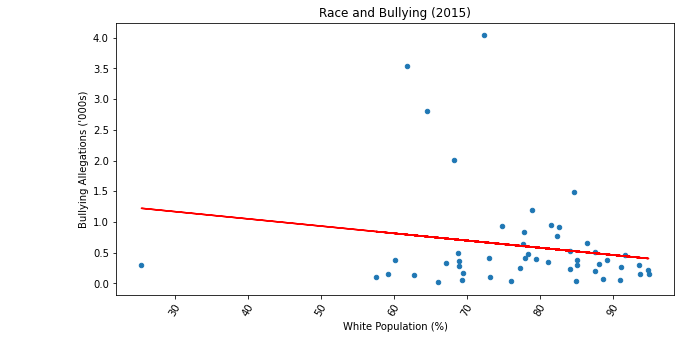

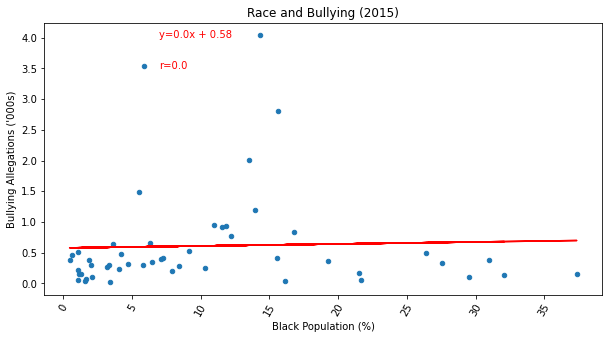

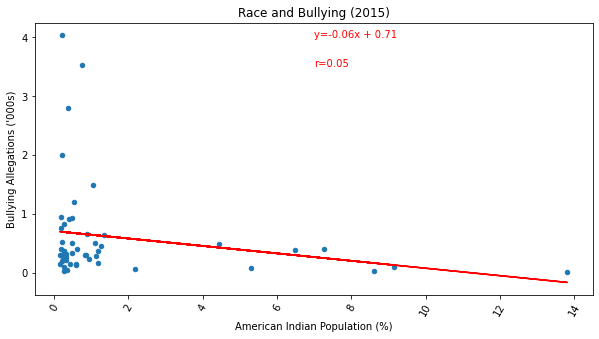

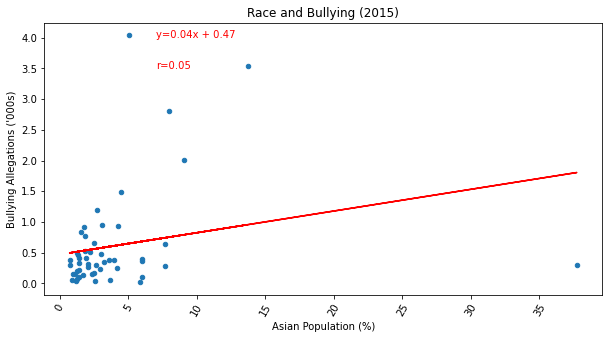

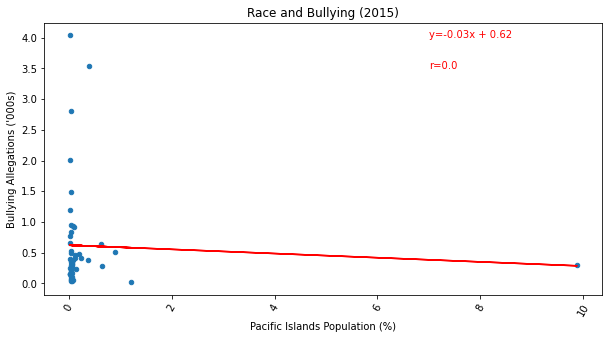

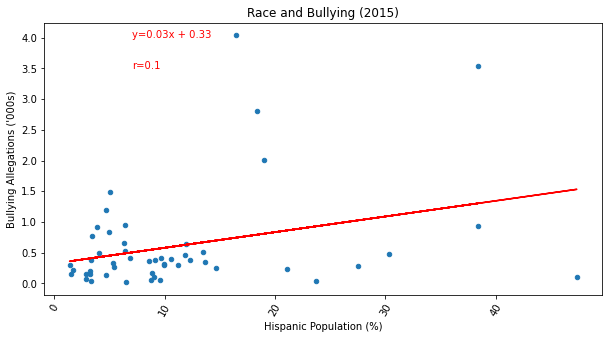

In [15]:
# Plot ethnicities and bullying allegations (due to race) by state to see if racial bullying allegations

w_pop = bully_demo_df["White"]/bully_demo_df["Population"]*100
b_pop = bully_demo_df["Black"]/bully_demo_df["Population"]*100
n_pop = bully_demo_df["American Indian"]/bully_demo_df["Population"]*100
a_pop = bully_demo_df["Asian"]/bully_demo_df["Population"]*100
pi_pop = bully_demo_df["Pacific Islands"]/bully_demo_df["Population"]*100
h_pop = bully_demo_df["Hispanic"]/bully_demo_df["Population"]*100
allegations = bully_demo_df["Alleged_Racial_Harassment"]/1000

ethnicity_df_list = [w_pop,b_pop,n_pop,a_pop,pi_pop,h_pop]
ethnicity_list = ["White","Black","American Indian","Asian","Pacific Islands","Hispanic"]

count=0

for ethnicity in ethnicity_df_list:
    ethnicity_df = pd.DataFrame({"Ethnicity":ethnicity, "Allegations": allegations})

    ethnicity_df.plot(kind="scatter",x="Ethnicity",y="Allegations", rot=60,figsize=(10,5))
    plt.xlabel(f"{ethnicity_list[count]} Population (%)")
    plt.ylabel("Bullying Allegations ('000s)")
    plt.title("Race and Bullying (2015)")
    
    (slope, intercept, r, p, sem) = linregress(ethnicity_df["Ethnicity"], ethnicity_df["Allegations"])
    fit = slope * ethnicity_df["Ethnicity"] + intercept
    line_eq = f"y={round(slope,2)}x + {round(intercept,2)}"
    r_value = f"r={round(r**2,2)}"
    plt.plot(ethnicity_df["Ethnicity"],fit,"-r")
    plt.annotate(line_eq, (7,4),color="red")
    plt.annotate(r_value, (7,3.5), color="red")
    
    plt.savefig(f"../Output/Images/{ethnicity_list[count]}_Bullying.png")
    
    count=count+1
    

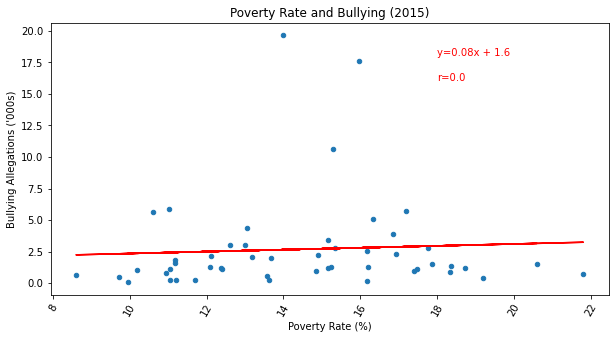

In [16]:
# Plot poverty rate and bullying allegations by state to see if poverty rate affects bullying allegations


poverty = bully_demo_df["Poverty Rate"]
allegations = bully_demo_df["Total_Allegations"]/1000


population_df = pd.DataFrame({"Poverty Rate":poverty, "Allegations": allegations})
population_df.plot(kind="scatter",x="Poverty Rate",y="Allegations", rot=60,figsize=(10,5))

(slope, intercept, r, p, sem) = linregress(population_df["Poverty Rate"], population_df["Allegations"])
fit = slope * population_df["Poverty Rate"] + intercept
line_eq = f"y={round(slope,2)}x + {round(intercept,2)}"
r_value = f"r={round(r**2,2)}"
plt.plot(population_df["Poverty Rate"],fit,"-r")
plt.annotate(line_eq, (18,18),color="red")
plt.annotate(r_value, (18,16), color="red")

plt.xlabel("Poverty Rate (%)")
plt.ylabel("Bullying Allegations ('000s)")
plt.title("Poverty Rate and Bullying (2015)")

plt.savefig(f"../Output/Images/Poverty_Bullying.png")

plt.show()

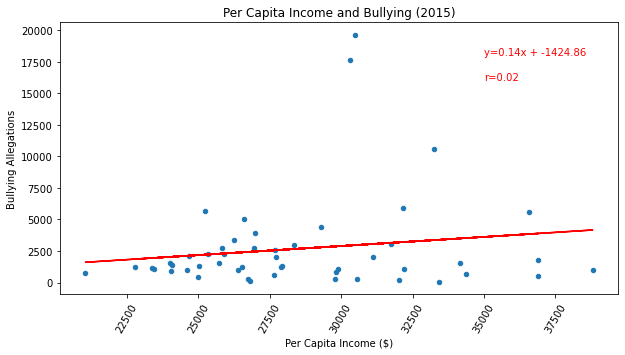

In [17]:
# Plot per capita income and bullying allegations by state to see if poverty rate affects bullying allegations


income = bully_demo_df["Per Capita Income"]
allegations = bully_demo_df["Total_Allegations"]


population_df = pd.DataFrame({"Per Capita Income":income, "Allegations": allegations})
population_df.plot(kind="scatter",x="Per Capita Income",y="Allegations", rot=60,figsize=(10,5))

(slope, intercept, r, p, sem) = linregress(population_df["Per Capita Income"], population_df["Allegations"])
fit = slope * population_df["Per Capita Income"] + intercept
line_eq = f"y={round(slope,2)}x + {round(intercept,2)}"
r_value = f"r={round(r**2,2)}"
plt.plot(population_df["Per Capita Income"],fit,"-r")
plt.annotate(line_eq, (35000,18000),color="red")
plt.annotate(r_value, (35000,16000), color="red")


plt.xlabel("Per Capita Income ($)")
plt.ylabel("Bullying Allegations")
plt.title("Per Capita Income and Bullying (2015)")

plt.savefig(f"../Output/Images/PerCapitaIncome_Bullying.png")

plt.show()

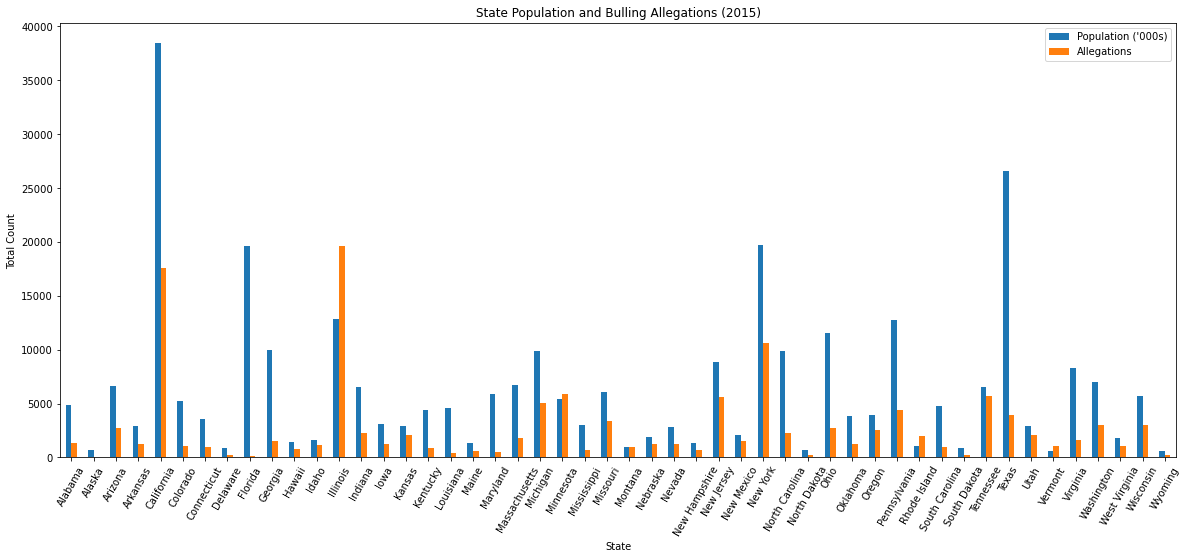

In [199]:
# Plot population and bullying allegations by state to see if cases numbers align with population

states = bully_demo_df["State"].tolist()
population = bully_demo_df["Population"]/1000
allegations = bully_demo_df["Total_Allegations"]

x_axis = np.arange(50)
tick_locations = [value for value in x_axis]

population_df = pd.DataFrame({"Population ('000s)":population, "Allegations": allegations})
population_df.plot(kind="bar",rot=60,figsize=(20,8))
plt.xticks(tick_locations,states)
plt.xlabel("State")
plt.ylabel("Total Count")
plt.title("State Population and Bulling Allegations (2015)")
plt.show()

In [62]:
# Import latitude & longitude of states and merge with bullying data

states_df = pd.read_csv("../Input/state_locs.csv")
states_df = states_df.rename(columns={"name":"State"})
states_df = states_df.drop(columns=["state"])
states_bully_df = pd.merge(states_df, bully_df, on="State")
states_bully_df.head()

,latitude,longitude,State,Alleged_Sexual_Harassment,Alleged_Racial_Harassment,Alleged_Disability_Harassment,Alleged_Orientation_Harassment,Alleged_Religion_Harassment,Total_Allegations
0,63.588753,-154.493062,Alaska,0,0,0,0,0,0
1,63.588753,-154.493062,Alaska,0,0,0,0,0,0
2,63.588753,-154.493062,Alaska,0,0,0,0,0,0
3,63.588753,-154.493062,Alaska,0,0,0,0,0,0
4,63.588753,-154.493062,Alaska,0,0,0,0,0,0


In [30]:
# Create heat map of bullying allegations across the US

fig = gmaps.figure()

locations = states_bully_df[["latitude","longitude"]]
bullying = states_bully_df["Total_Allegations"].astype(float)

heat_layer = gmaps.heatmap_layer(locations,weights=bullying,dissipating=False,max_intensity=bullying.max(),
                                point_radius=5)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [55]:
# Capitalize state names to match values in education data

capital_states = []

for index,row in allegations_by_state.iterrows():
    capital_state = row["State"].upper()
    capital_states.append(capital_state)

allegations_by_state["State"] = capital_states
allegations_by_state.head()

,State,Alleged_Sexual_Harassment,Alleged_Racial_Harassment,Alleged_Disability_Harassment,Alleged_Orientation_Harassment,Alleged_Religion_Harassment,Total_Allegations
0,ALABAMA,569,501,81,193,13,1357
1,ALASKA,27,17,4,11,0,59
2,ARIZONA,1547,485,218,426,104,2780
3,ARKANSAS,595,411,102,111,8,1227
4,CALIFORNIA,8640,3537,2037,2110,1296,17620


In [56]:
# Merge bullying data with education data


bully_ed_df = pd.merge(allegations_by_state,math_df, on="State")
bully_ed_df.head()

,State,Alleged_Sexual_Harassment,Alleged_Racial_Harassment,Alleged_Disability_Harassment,Alleged_Orientation_Harassment,Alleged_Religion_Harassment,Total_Allegations,School Year,Description,Value,Number of Test Takers,Academic Subject,Category,Age/Grade,Grade Level,LEP Status,English Proficiency,Language,Progress Level
0,ALABAMA,569,501,81,193,13,1357,2015-2016,Performance on Statewide Mathematics Assessment,LT50,159.0,Mathematics,Children with disabilities,NaN,All Grades,NaN,NaN,NaN,NaN
1,ALABAMA,569,501,81,193,13,1357,2015-2016,Performance on Statewide Mathematics Assessment,LT50,44.0,Mathematics,Homeless,NaN,All Grades,NaN,NaN,NaN,NaN
2,ALABAMA,569,501,81,193,13,1357,2015-2016,Performance on Statewide Mathematics Assessment,LT50,278.0,Mathematics,English Learner,NaN,All Grades,NaN,NaN,NaN,NaN
3,ALABAMA,569,501,81,193,13,1357,2015-2016,Performance on Statewide Mathematics Assessment,GE50,12.0,Mathematics,Asian / Pacific Islander,NaN,All Grades,NaN,NaN,NaN,NaN
4,ALABAMA,569,501,81,193,13,1357,2015-2016,Performance on Statewide Mathematics Assessment,LT50,74.0,Mathematics,Black or African American,NaN,All Grades,NaN,NaN,NaN,NaN


In [43]:
# Create combined DataFrame with all state assessment scores by state

frames = [math_df,reading_df,science_df]

tests_df = pd.concat(frames)
tests_df.head()

,School Year,State,Description,Value,Number of Test Takers,Academic Subject,Category,Age/Grade,Grade Level,LEP Status,English Proficiency,Language,Progress Level
123,2015-2016,ALABAMA,Performance on Statewide Mathematics Assessment,LT50,159.0,Mathematics,Children with disabilities,NaN,All Grades,NaN,NaN,NaN,NaN
124,2015-2016,ALABAMA,Performance on Statewide Mathematics Assessment,LT50,44.0,Mathematics,Homeless,NaN,All Grades,NaN,NaN,NaN,NaN
125,2015-2016,ALABAMA,Performance on Statewide Mathematics Assessment,LT50,278.0,Mathematics,English Learner,NaN,All Grades,NaN,NaN,NaN,NaN
126,2015-2016,ALABAMA,Performance on Statewide Mathematics Assessment,GE50,12.0,Mathematics,Asian / Pacific Islander,NaN,All Grades,NaN,NaN,NaN,NaN
127,2015-2016,ALABAMA,Performance on Statewide Mathematics Assessment,LT50,74.0,Mathematics,Black or African American,NaN,All Grades,NaN,NaN,NaN,NaN


In [44]:
# Find scores greater than or equal to 50%

ge50_counts = []

for state in us.states.STATES:
    upper_state = str(state).upper()
    ge50 = tests_df.loc[(tests_df["Value"]=="GE50") & (tests_df["State"]==upper_state)]
    ge50_count = ge50["Value"].count()
    ge50_counts.append(ge50_count)

Text(13000, 65000, 'r=0.1')

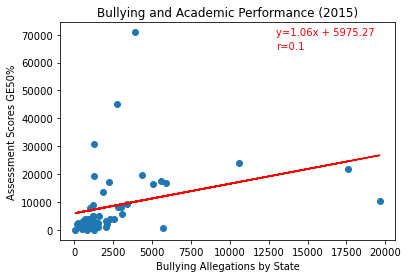

In [45]:
# Plot scores GE50 vs. Bulling Allegations

y_axis = ge50_counts
x_axis = allegations_by_state["Total_Allegations"]

plt.scatter(x_axis,y_axis)
plt.xlabel("Bullying Allegations by State")
plt.ylabel("Assessment Scores GE50%")
plt.title("Bullying and Academic Performance (2015)")

(slope, intercept, r, p, sem) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
line_eq = f"y={round(slope,2)}x + {round(intercept,2)}"
r_value = f"r={round(r**2,2)}"
plt.plot(x_axis,fit,"-r")
plt.annotate(line_eq, (13000,70000),color="red")
plt.annotate(r_value, (13000,65000), color="red")



In [46]:
# Find scores less than 50%

lt50_counts = []

for state in us.states.STATES:
    upper_state = str(state).upper()
    lt50 = tests_df.loc[(tests_df["Value"]=="LT50") & (tests_df["State"]==upper_state)]
    lt50_count = lt50["Value"].count()
    lt50_counts.append(lt50_count)

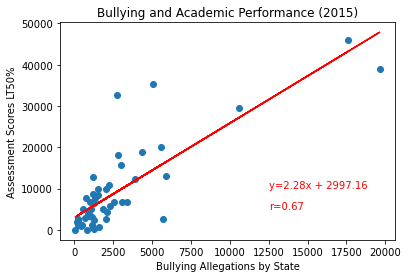

In [47]:
# Plot scores LT50 vs. Bulling Allegations

y_axis = lt50_counts
x_axis = allegations_by_state["Total_Allegations"]

plt.scatter(x_axis,y_axis)
plt.xlabel("Bullying Allegations by State")
plt.ylabel("Assessment Scores LT50%")
plt.title("Bullying and Academic Performance (2015)")

(slope, intercept, r, p, sem) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
line_eq = f"y={round(slope,2)}x + {round(intercept,2)}"
r_value = f"r={round(r**2,2)}"
plt.plot(x_axis,fit,"-r")
plt.annotate(line_eq, (12500,10000),color="red")
plt.annotate(r_value, (12500,5000), color="red")

plt.savefig(f"../Output/Images/LT50_Test_Scores.png")

In [115]:
# Find graduation rates greater than or equal to 50%

ge50_counts = []

for state in us.states.STATES:
    upper_state = str(state).upper()
    ge50 = grad_df.loc[(grad_df["Value"]=="GE50") & (grad_df["State"]==upper_state)]
    ge50_count = ge50["Value"].count()
    ge50_counts.append(ge50_count)

Text(12500, 3250, 'r=0.13')

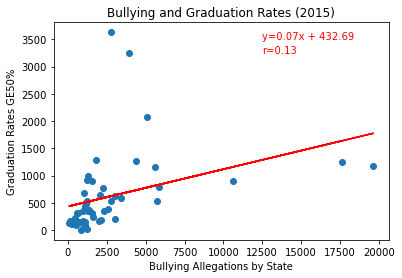

In [149]:
# Plot graduation rates GE50 vs. Bulling Allegations

y_axis = ge50_counts
x_axis = allegations_by_state["Total_Allegations"]

plt.scatter(x_axis,y_axis)
plt.xlabel("Bullying Allegations by State")
plt.ylabel("Graduation Rates GE50%")
plt.title("Bullying and Graduation Rates (2015)")

(slope, intercept, r, p, sem) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
line_eq = f"y={round(slope,2)}x + {round(intercept,2)}"
r_value = f"r={round(r**2,2)}"
plt.plot(x_axis,fit,"-r")
plt.annotate(line_eq, (12500,3500),color="red")
plt.annotate(r_value, (12500,3250), color="red")

In [211]:
# Find graduation rates less than 50%

lt50_counts = []

for state in us.states.STATES:
    upper_state = str(state).upper()
    lt50 = grad_df.loc[(grad_df["Value"]=="LT50") & (grad_df["State"]==upper_state)]
    lt50_count = lt50["Value"].count()
    lt50_counts.append(lt50_count)

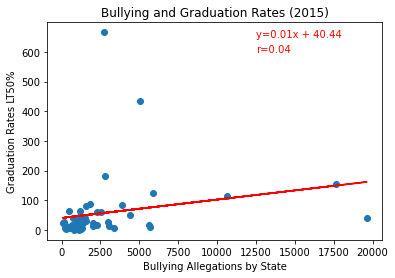

In [213]:
# Plot graduation rates LT50 vs. Bulling Allegations

y_axis = lt50_counts
x_axis = allegations_by_state["Total_Allegations"]

plt.scatter(x_axis,y_axis)
plt.xlabel("Bullying Allegations by State")
plt.ylabel("Graduation Rates LT50%")
plt.title("Bullying and Graduation Rates (2015)")

(slope, intercept, r, p, sem) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
line_eq = f"y={round(slope,2)}x + {round(intercept,2)}"
r_value = f"r={round(r**2,2)}"
plt.plot(x_axis,fit,"-r")
plt.annotate(line_eq, (12500,650),color="red")
plt.annotate(r_value, (12500,600), color="red")

plt.savefig(f"../Output/Images/LT50_Grad_Rates.png")